In [1]:
from transformers import pipeline
import numpy as np
import pandas as pd
import gzip
import fastparquet
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertModel

In [2]:
# read conceptnet
conceptnet = pd.read_parquet('conceptnet_small.parquet.gzip',columns=['uri','relation','start_node','end_node','info'])

# choose room for which to search relations
room =  'kitchen'
room = '/c/en/' + room
node = 'end_node'
object_relations = conceptnet[conceptnet[node] == room]

# create list of objects typically associated with chosen room type
objs = []

for i in range(object_relations.shape[0]):
    objs.append(object_relations['start_node'].iloc[i][6:])
    

In [3]:
# object list pre-processing for use with bert

# use second word in word pairing
objects = []

for i in range(len(objs)):
    tmp = str(objs[i]).split('_')
    objects.append(tmp[len(tmp)-1])
    
# get objects (see post_objects.xlsx for more preprocessing info)
all_objs = pd.read_excel('post_objects.xlsx')
landmarks = all_objs['landmark'].iloc[0:14]
objects = all_objs['target']

In [126]:
# load bert
unmasker = pipeline('fill-mask', model = 'bert-base-uncased')

# tokenize objects for bert
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

landmark = []

for i in range(len(landmarks)):
    new = tokenizer.tokenize(landmarks[i])
    
    if len(new[0]) == len(landmarks[i]):
        landmark.append(new[0])
        
target = []

for i in range(len(objects)):
    new = tokenizer.tokenize(objects[i])
    
    if len(new[0]) == len(objects[i]):
        target.append(new[0])


In [127]:
# co-occurrence mat
cooccur = np.zeros((len(landmark),len(target)))

for i in range(len(landmark)):
    for j in range(len(target)):
        sentence = 'The [MASK] is on the ' + landmark[i]
        result = unmasker(sentence, targets = target[j])
        cooccur[i,j] = result[0].get("score")

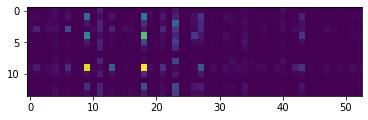

In [128]:
# visualize cooccurrence matrix
plt.imshow(cooccur)

In [133]:
# visualize landmark/target object pairs
pair = []
for i in range(len(target)):
    idx = np.flip(np.argsort(cooccur[:,i]))
    pair.append(landmark[idx[0]])
    
temp = pd.DataFrame(target)
temp.insert(1,"landmark",pair)
temp